In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

In [16]:
def normalize_frame(frame):
    """Normalize the frame to uint8 format."""
    min_val = frame.min()
    max_val = frame.max()
    if max_val == min_val:
        # all elements initialized to zero
        # the default data type is float64
        return np.zeros_like(frame, dtype=np.uint8)
    frame = (frame - min_val) * (255.0 / (max_val - min_val))
    return frame.astype(np.uint8)

In [2]:
def create_frequency_grid(shape):
    
    """create a grid of distances from the 
    center representing frequency magnitudes."""
    
    rows, cols = shape
    crow, ccol = rows // 2, cols // 2  

    # create grid of coordinates
    u, v = np.ogrid[:rows, :cols]
    
    # calculate the distance from the center
    d = np.sqrt((u - crow)**2 + (v - ccol)**2)
    
    # calculate the maximum distance 
    # Nyquist frequency
    d_max = np.sqrt((crow)**2 + (ccol)**2)
    
    # normalize distances to get frequency ratios
    frequency_ratio = d / d_max
    
    return frequency_ratio

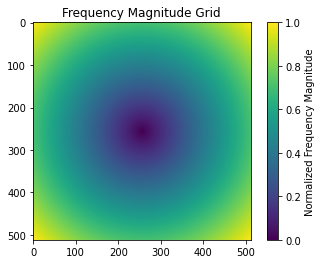

In [3]:
shape = (512, 512)
frequency_grid = create_frequency_grid(shape)

plt.imshow(frequency_grid, cmap='viridis')
plt.colorbar(label='Normalized Frequency Magnitude')
plt.title('Frequency Magnitude Grid')
plt.show()

In [5]:
u, v = np.ogrid[:4, :5]
print(u, v)

[[0]
 [1]
 [2]
 [3]] [[0 1 2 3 4]]


In [6]:
def create_bandpass_filter(shape, low_cutoff, high_cutoff):
    
    """"""
    
    rows, cols = shape
    crow, ccol = rows // 2, cols // 2  

    # create grid of coordinates
    u, v = np.ogrid[:rows, :cols]
    
    # calculate the distance from the center
    d = np.sqrt((u - crow)**2 + (v - ccol)**2)
    
    mask = np.logical_and(d >= low_cutoff, d <= high_cutoff).astype(np.uint8)
    
    return mask

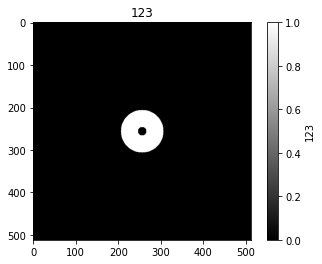

In [8]:
shape = (512, 512)

low_cutoff = 10
high_cutoff = 50

frequency_grid = create_bandpass_filter(shape, low_cutoff, high_cutoff)

plt.imshow(frequency_grid, cmap='gray')
plt.colorbar(label='123')
plt.title('123')
plt.show()

          +-------------------------------+
          |           Start                |
          +-------------------------------+
                     |
                     v
          +-------------------------------+
          | Create Output Directory        |
          +-------------------------------+
                     |
                     v
          +-------------------------------+
          | Open Video File                |
          |  (Error Handling)              |
          +-------------------------------+
                     |
                     v
          +-------------------------------+
          | Get Video Properties           |
          +-------------------------------+
                     |
                     v
          +-------------------------------+
          | Create VideoWriters            |
          +-------------------------------+
                     |
                     v
          +-------------------------------+
          | Define Frequency Bands and     |
          | Precompute Masks               |
          +-------------------------------+
                     |
                     v
          +-------------------------------+
          | Process Each Frame             |
          |  + Read Frame                  |
          |  + Convert to Grayscale        |
          |  + Perform FFT                 |
          |  + Apply Frequency Masks       |
          |  + Write Frame to Output Videos|
          +-------------------------------+
                     |
                     v
          +-------------------------------+
          | Release Resources              |
          +-------------------------------+
                     |
                     v
          +-------------------------------+
          | Print Completion Message       |
          +-------------------------------+
                     |
                     v
          +-------------------------------+
          |             End                |
          +-------------------------------+


In [17]:
def decompose_video(video_path, num_videos, output_dir):
    
    # Create Output Directory 
    os.makedirs(output_dir, exist_ok = True)
    
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        raise ValueError(f"error opening video file: {video_path}")
    
    
    # get Video Properties
    
    frame_width=int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height=int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps=int(cap.get(cv2.CAP_PROP_FPS))
    total_frames=int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    #  Create VideoWriters  
    writers=[]
    
    for i in range(num_videos):
        
        out_path=os.path.join(output_dir, f"output_{i+1}.mp4")
        
        writer = cv2.VideoWriter(out_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))
        
        writers.append(writer)
        
    # Define Frequency Bands and Precompute Masks  
    
    max_radius = np.sqrt((frame_height // 2)**2 + (frame_width // 2)**2)
    
    step = max_radius / num_videos
    
    masks = [create_bandpass_filter((frame_height, frame_width), i*step, (i+1)*step)
             for i in range(num_videos)]
    
    # Process Each Frame 
    
    while cap.isOpened():
        ret, frame = cap.read()
        
        if not ret:
            break
        
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        
        f_transform = np.fft.fft2(gray_frame)
        f_shift = np.fft.fftshift(f_transform)
        
        for i, mask in enumerate(masks):
            
            f_component = f_shift * mask
            
            f_component_shift = np.fft.ifftshift(f_component)
            
            img_back = np.fft.ifft2(f_component_shift)
            
            img_back = np.abs(img_back)
            
            img_back = normalize_frame(img_back)
            
            img_back_bgr = cv2.cvtColor(img_back, cv2.COLOR_GRAY2BGR)
            
            writers[i].write(img_back_bgr)
        
    cap.release()
    for write in writers:
        writer.release()
        
    # Print Completion Message 
    print("Time lab retreat done!")

In [19]:
video_path = 'cater.avi'
num_videos = 5

output_dir = 'retreat_lei'

decompose_video(video_path, num_videos, output_dir)

Time lab retreat done!
